In [1]:
import numpy as np
import pandas as pd
import polars as pl



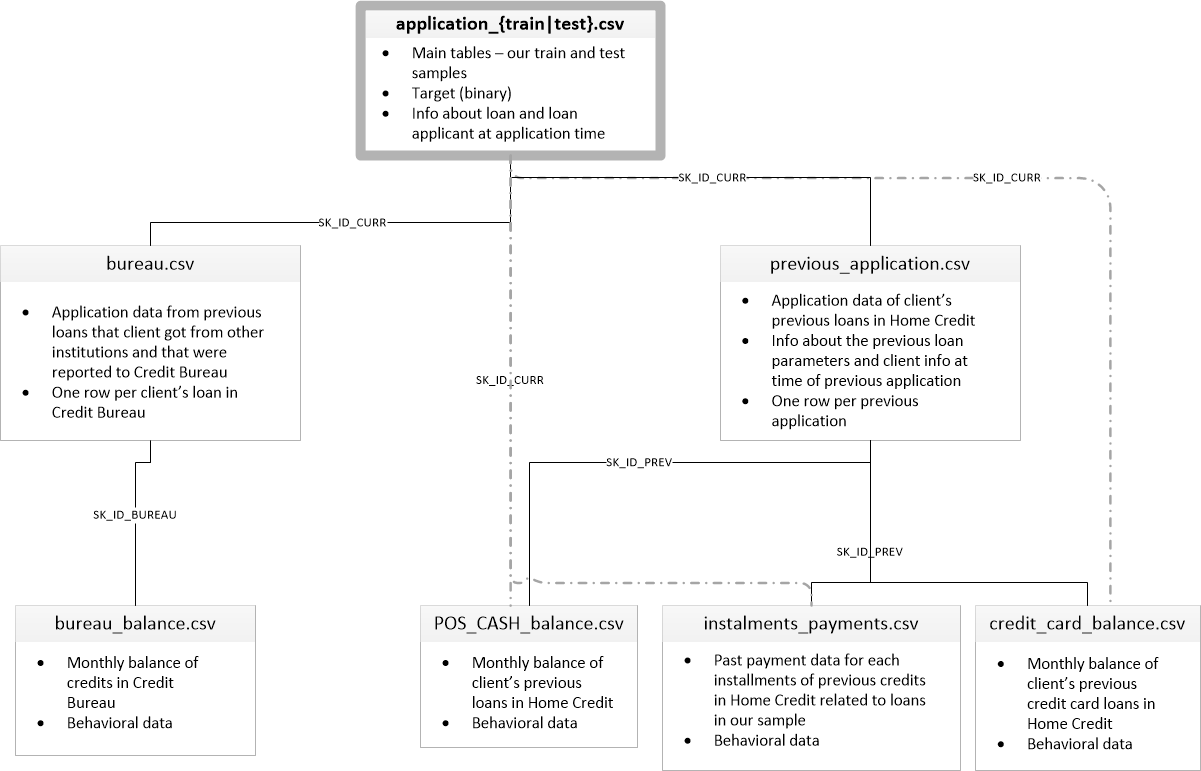

## Polars: What and Why?

Polars distinguishes itself in the realm of large dataset manipulation through its advanced optimization of execution graphs and its implementation of lazy loading. When operating in lazy mode, Polars defers computations, instead building an execution graph. This graph represents the sequence of data transformations and is optimized before any actual computation takes place. This optimization can involve reordering operations, merging similar tasks, and eliminating redundant steps, which greatly enhances the efficiency of data processing.

The lazy loading feature allows Polars to handle datasets that are larger than the available memory, as it doesn't load the entire dataset into memory at once. Instead, data is read and processed in chunks, making it possible to work with very large files that would otherwise be impossible to handle. This approach not only reduces memory usage but also speeds up many operations, as the optimized execution graph is applied to each chunk of data, ensuring that resource-intensive operations are conducted as efficiently as possible. These features make Polars an incredibly powerful tool for data scientists and analysts dealing with large and complex datasets, where performance and memory utilization are critical considerations.

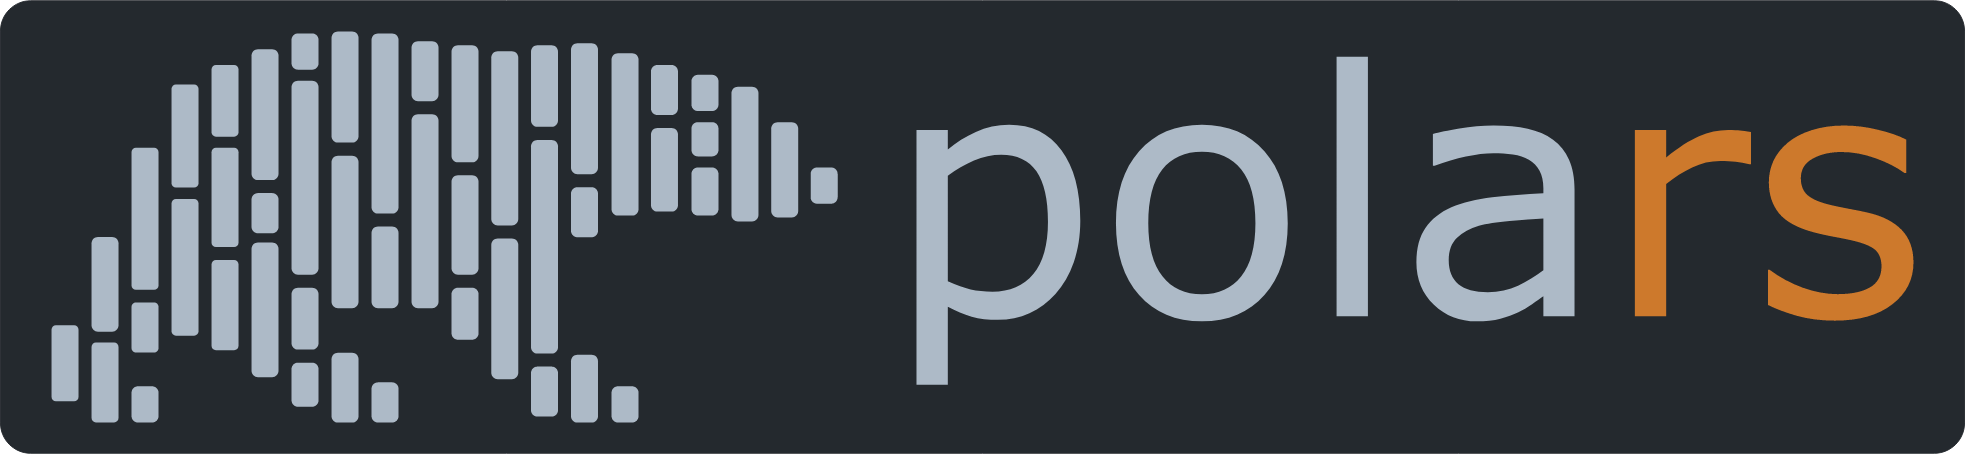

## Scanning tables using lazy load

In [2]:
lazy_application_train_df = pl.scan_csv("data/application_train.csv")
lazy_bureau_df = pl.scan_csv("data/bureau.csv")
lazy_bureau_balance_df = pl.scan_csv("data/bureau_balance.csv")

lazy_prev_application_df = pl.scan_csv("data/previous_application.csv")
lazy_cred_card_balance_df = pl.scan_csv("data/credit_card_balance.csv")
lazy_pos_cash_balance_df = pl.scan_csv("data/POS_CASH_balance.csv")
lazy_install_payments_df = pl.scan_csv("data/installments_payments.csv")


## bureau data

In [3]:
bureau_balance_df = lazy_bureau_balance_df.collect()



In [4]:
#Grouping bureau_balance

grouped_bureau_balance_df = bureau_balance_df.group_by("SK_ID_BUREAU").agg([
    pl.col("MONTHS_BALANCE").mean().alias("meanMONTHS_BALANCE"),

    #taking quantiles
    pl.quantile("MONTHS_BALANCE", 0.25).alias("25Q_MONTHS_BALANCE"),
    pl.quantile("MONTHS_BALANCE", 0.75).alias("75Q_MONTHS_BALANCE"),
    pl.std("MONTHS_BALANCE").alias("STD_MONTHS_BALANCE"),
    pl.col("STATUS").last().alias("lastSTATUS"),
    pl.col("STATUS").mode().first().alias("modeSTATUS")
]).lazy()




In [5]:
#Joing bureau tables
merged_bureau_data = lazy_bureau_df.join(grouped_bureau_balance_df, on="SK_ID_BUREAU", how="left")

numerical_cols = [
    'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
    'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
    'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
    'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'meanMONTHS_BALANCE',
    'STD_MONTHS_BALANCE'
]

categorical_cols = [
    'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'lastSTATUS', 'modeSTATUS'
]


In [6]:
# Group by SK_ID_CURR and aggregate
grouped_bureau_df = merged_bureau_data.group_by("SK_ID_CURR").agg([
    # Apply mean and std for numerical columns
    *[pl.col(col).mean().alias(f'{col}_mean') for col in numerical_cols],
    *[pl.col(col).std().alias(f'{col}_std') for col in ["AMT_CREDIT_SUM", ["CNT_CREDIT_PROLONG"]]],
    # Apply mode for categorical columns
    *[pl.col(col).mode().first().alias(f'{col}_mode') for col in categorical_cols]  # Using mode().first() to get the single mode value
])



In [7]:
grouped_bureau_df = grouped_bureau_df.collect()


In [8]:
#saving intermediat step
grouped_bureau_df.write_csv("processsing/grouped_bureau.csv", float_precision=3)


### Previous application: preparing tables


In [9]:
## Grouping credit card balance table by SK_ID_PREV

grouped_cred_card_df = lazy_cred_card_balance_df.group_by("SK_ID_PREV").agg([
    pl.col('MONTHS_BALANCE').mean().alias('MONTHS_BALANCE_mean'),
    pl.col('AMT_BALANCE').mean().alias('AMT_BALANCE_mean'),
    pl.col('AMT_CREDIT_LIMIT_ACTUAL').mean().alias('AMT_CREDIT_LIMIT_ACTUAL_mean'),
    pl.col('AMT_DRAWINGS_ATM_CURRENT').mean().alias('AMT_DRAWINGS_ATM_CURRENT_mean'),
    pl.col('AMT_DRAWINGS_CURRENT').mean().alias('AMT_DRAWINGS_CURRENT_mean'),
    pl.col('AMT_DRAWINGS_OTHER_CURRENT').mean().alias('AMT_DRAWINGS_OTHER_CURRENT_mean'),
    pl.col('AMT_DRAWINGS_POS_CURRENT').mean().alias('AMT_DRAWINGS_POS_CURRENT_mean'),
    pl.col('AMT_INST_MIN_REGULARITY').mean().alias('AMT_INST_MIN_REGULARITY_mean'),
    pl.col('AMT_PAYMENT_CURRENT').mean().alias('AMT_PAYMENT_CURRENT_mean'),
    pl.col('AMT_PAYMENT_TOTAL_CURRENT').mean().alias('AMT_PAYMENT_TOTAL_CURRENT_mean'),
    pl.col('AMT_RECEIVABLE_PRINCIPAL').mean().alias('AMT_RECEIVABLE_PRINCIPAL_mean'),
    pl.col('AMT_RECIVABLE').mean().alias('AMT_RECIVABLE_mean'),
    pl.col('AMT_TOTAL_RECEIVABLE').mean().alias('AMT_TOTAL_RECEIVABLE_mean'),
    pl.col('CNT_DRAWINGS_ATM_CURRENT').mean().alias('CNT_DRAWINGS_ATM_CURRENT_mean'),
    pl.col('CNT_DRAWINGS_CURRENT').mean().alias('CNT_DRAWINGS_CURRENT_mean'),
    pl.col('CNT_DRAWINGS_OTHER_CURRENT').mean().alias('CNT_DRAWINGS_OTHER_CURRENT_mean'),
    pl.col('CNT_DRAWINGS_POS_CURRENT').mean().alias('CNT_DRAWINGS_POS_CURRENT_mean'),
    pl.col('CNT_INSTALMENT_MATURE_CUM').mean().alias('CNT_INSTALMENT_MATURE_CUM_mean'),
    pl.col('SK_DPD').mean().alias('SK_DPD_mean'),
    pl.col('SK_DPD_DEF').mean().alias('SK_DPD_DEF_mean'),
    pl.col('NAME_CONTRACT_STATUS').mode().first().alias('NAME_CONTRACT_STATUS_mode')
])

In [10]:
grouped_cred_card_df = grouped_cred_card_df.collect()

In [11]:
grouped_cred_card_df.write_csv("processsing/grouped_cred_card.csv", float_precision=3)

In [12]:
## Grouping POS_balance table
grouped_pos_balance_df = lazy_pos_cash_balance_df.group_by("SK_ID_PREV").agg(
    [
        pl.col("MONTHS_BALANCE").mean().alias("POS_MONTHS_BALANCE_mean"),
        pl.col("CNT_INSTALMENT").mean().alias("CNT_INSTALMENT_mean"),
        pl.col("CNT_INSTALMENT_FUTURE").mean().alias("CNT_INSTALMENT_FUTURE_mean"),
        pl.col("MONTHS_BALANCE").std().alias("POS_MONTHS_BALANCE_std"),
        pl.col("CNT_INSTALMENT").std().alias("CNT_INSTALMENT_std"),
        pl.col("CNT_INSTALMENT_FUTURE").std().alias("CNT_INSTALMENT_FUTURE_std"),
        pl.col("NAME_CONTRACT_STATUS").mode().first().alias("POS_NAME_CONTRACT_STATUS_mode"),
    ]
)


In [13]:
grouped_pos_balance_df = grouped_pos_balance_df.collect()

In [14]:
grouped_pos_balance_df.write_csv("processsing/grouped_pos_balance_df", float_precision=3)

In [15]:
## Grouping installments payments table
grouped_install_payments_df = lazy_install_payments_df.group_by("SK_ID_PREV").agg(
    [
        pl.col("NUM_INSTALMENT_NUMBER").mean().alias("NUM_INSTALMENT_NUMBER_mean"),
        pl.col("DAYS_INSTALMENT").mean().alias("DAYS_INSTALMENT_mean"),
        pl.col("DAYS_ENTRY_PAYMENT").mean().alias("DAYS_ENTRY_PAYMENT_mean"),
        pl.col("AMT_INSTALMENT").mean().alias("AMT_INSTALMENT_mean"),
        pl.col("AMT_PAYMENT").mean().alias("AMT_PAYMENT_mean"),
        pl.col("NUM_INSTALMENT_NUMBER").std().alias("NUM_INSTALMENT_NUMBER_std"),
        pl.col("DAYS_INSTALMENT").std().alias("DAYS_INSTALMENT_std"),
        pl.col("DAYS_ENTRY_PAYMENT").std().alias("DAYS_ENTRY_PAYMENT_std"),
        pl.col("AMT_INSTALMENT").std().alias("AMT_INSTALMENT_std"),
        pl.col("AMT_PAYMENT").std().alias("AMT_PAYMENT_std")
    ]
)

In [16]:
grouped_install_payments_df = grouped_install_payments_df.collect()


In [17]:
grouped_install_payments_df.write_csv("processsing/grouped_install_payments.csv", float_precision=3)


Merging tables to previous application table to get the whole picture

In [18]:
merged_previous_application_df = lazy_prev_application_df.join(grouped_pos_balance_df.lazy(),
                                                               how="left", on="SK_ID_PREV")


merged_previous_application_df = merged_previous_application_df.join(grouped_install_payments_df.lazy(),
                                                               how="left", on="SK_ID_PREV")

merged_previous_application_df = merged_previous_application_df.join(grouped_cred_card_df.lazy(),
                                                               how="left", on="SK_ID_PREV")

In [20]:
merged_previous_application_df = merged_previous_application_df.collect()

In [21]:
merged_previous_application_df.write_csv("processsing/merged_prev_application.csv", float_precision=3)

In [22]:
merged_previous_application_df = merged_previous_application_df.lazy()

### Grouping features by batches to avoid crashing the kernel

**Grouping only categorical features**

In [25]:
grouped_merged_prev_app_cat_df = merged_previous_application_df.group_by("SK_ID_CURR").agg(
    [
        # Mode aggregations for categorical features
        pl.col("NAME_CONTRACT_TYPE").mode().first().alias("NAME_CONTRACT_TYPE_mode"),
        pl.col("WEEKDAY_APPR_PROCESS_START").mode().first().alias("WEEKDAY_APPR_PROCESS_START_mode"),
        pl.col("FLAG_LAST_APPL_PER_CONTRACT").mode().first().alias("FLAG_LAST_APPL_PER_CONTRACT_mode"),
        pl.col("NAME_CASH_LOAN_PURPOSE").mode().first().alias("NAME_CASH_LOAN_PURPOSE_mode"),
        pl.col("NAME_CONTRACT_STATUS").mode().first().alias("NAME_CONTRACT_STATUS_mode"),
        pl.col("NAME_PAYMENT_TYPE").mode().first().alias("NAME_PAYMENT_TYPE_mode"),
        pl.col("CODE_REJECT_REASON").mode().first().alias("CODE_REJECT_REASON_mode"),
        pl.col("NAME_TYPE_SUITE").mode().first().alias("NAME_TYPE_SUITE_mode"),
        pl.col("NAME_CLIENT_TYPE").mode().first().alias("NAME_CLIENT_TYPE_mode"),
        pl.col("NAME_GOODS_CATEGORY").mode().first().alias("NAME_GOODS_CATEGORY_mode"),
        pl.col("NAME_PORTFOLIO").mode().first().alias("NAME_PORTFOLIO_mode"),
        pl.col("NAME_PRODUCT_TYPE").mode().first().alias("NAME_PRODUCT_TYPE_mode"),
        pl.col("CHANNEL_TYPE").mode().first().alias("CHANNEL_TYPE_mode"),
        pl.col("NAME_SELLER_INDUSTRY").mode().first().alias("NAME_SELLER_INDUSTRY_mode"),
        pl.col("NAME_YIELD_GROUP").mode().first().alias("NAME_YIELD_GROUP_mode"),
        pl.col("PRODUCT_COMBINATION").mode().first().alias("PRODUCT_COMBINATION_mode"),
        
        
    ]
)

grouped_merged_prev_app_cat_df = grouped_merged_prev_app_cat_df.collect()
grouped_merged_prev_app_cat_df.write_csv("processsing/grouped_merged_prev_cat.csv")

**Grouping 1st part of numerical features**

In [26]:
grouped_merged_prev_app_num1_df = merged_previous_application_df.group_by("SK_ID_CURR").agg(
    [
    
        
        # # Mean aggregations for numeric features
        pl.col("AMT_ANNUITY").mean().alias("AMT_ANNUITY_mean"),
        pl.col("AMT_APPLICATION").mean().alias("AMT_APPLICATION_mean"),
        pl.col("AMT_CREDIT").mean().alias("AMT_CREDIT_mean"),
        pl.col("AMT_DOWN_PAYMENT").mean().alias("AMT_DOWN_PAYMENT_mean"),
        pl.col("AMT_GOODS_PRICE").mean().alias("AMT_GOODS_PRICE_mean"),
        pl.col("HOUR_APPR_PROCESS_START").mean().alias("HOUR_APPR_PROCESS_START_mean"),
        pl.col("NFLAG_LAST_APPL_IN_DAY").mean().alias("NFLAG_LAST_APPL_IN_DAY_mean"),
        pl.col("RATE_DOWN_PAYMENT").mean().alias("RATE_DOWN_PAYMENT_mean"),
        pl.col("RATE_INTEREST_PRIMARY").mean().alias("RATE_INTEREST_PRIMARY_mean"),
        pl.col("RATE_INTEREST_PRIVILEGED").mean().alias("RATE_INTEREST_PRIVILEGED_mean"),
        pl.col("DAYS_DECISION").mean().alias("DAYS_DECISION_mean"),
        pl.col("SELLERPLACE_AREA").mean().alias("SELLERPLACE_AREA_mean"),
        pl.col("CNT_PAYMENT").mean().alias("CNT_PAYMENT_mean"),
        pl.col("DAYS_FIRST_DRAWING").mean().alias("DAYS_FIRST_DRAWING_mean"),
        pl.col("DAYS_FIRST_DUE").mean().alias("DAYS_FIRST_DUE_mean"),
        pl.col("DAYS_LAST_DUE_1ST_VERSION").mean().alias("DAYS_LAST_DUE_1ST_VERSION_mean"),
        pl.col("DAYS_LAST_DUE").mean().alias("DAYS_LAST_DUE_mean"),
        pl.col("DAYS_TERMINATION").mean().alias("DAYS_TERMINATION_mean"),
        pl.col("NFLAG_INSURED_ON_APPROVAL").mean().alias("NFLAG_INSURED_ON_APPROVAL_mean"),
        pl.col("CNT_INSTALMENT_mean").mean().alias("CNT_INSTALMENT_mean"),
        pl.col("CNT_INSTALMENT_FUTURE_mean").mean().alias("CNT_INSTALMENT_FUTURE_mean"),
        pl.col("POS_MONTHS_BALANCE_std").mean().alias("POS_MONTHS_BALANCE_std"),
        pl.col("CNT_INSTALMENT_std").mean().alias("CNT_INSTALMENT_std"),
        pl.col("CNT_INSTALMENT_FUTURE_std").mean().alias("CNT_INSTALMENT_FUTURE_std"),
        pl.col("NUM_INSTALMENT_NUMBER_mean").mean().alias("NUM_INSTALMENT_NUMBER_mean"),
        pl.col("DAYS_INSTALMENT_mean").mean().alias("DAYS_INSTALMENT_mean"),
        pl.col("DAYS_ENTRY_PAYMENT_mean").mean().alias("DAYS_ENTRY_PAYMENT_mean"),
    ]
)

grouped_merged_prev_app_num1_df = grouped_merged_prev_app_num1_df.collect()
grouped_merged_prev_app_num1_df.write_csv("processsing/progrouped_merged_num1_cat.csv")

**Grouping 2nd part of numerical features**

In [28]:
grouped_merged_prev_app_num2_df = merged_previous_application_df.group_by("SK_ID_CURR").agg(
    [
    
        
        # # Mean aggregations for numeric features batch2

        pl.col("AMT_INSTALMENT_mean").mean().alias("AMT_INSTALMENT_mean"),
        pl.col("AMT_PAYMENT_mean").mean().alias("AMT_PAYMENT_mean"),
        pl.col("NUM_INSTALMENT_NUMBER_std").mean().alias("NUM_INSTALMENT_NUMBER_std"),
        pl.col("DAYS_INSTALMENT_std").mean().alias("DAYS_INSTALMENT_std"),
        pl.col("DAYS_ENTRY_PAYMENT_std").mean().alias("DAYS_ENTRY_PAYMENT_std"),
        pl.col("AMT_INSTALMENT_std").mean().alias("AMT_INSTALMENT_std"),
        pl.col("MONTHS_BALANCE_mean").mean().alias("MONTHS_BALANCE_mean"),
        pl.col("AMT_BALANCE_mean").mean().alias("AMT_BALANCE_mean"),
        pl.col("AMT_CREDIT_LIMIT_ACTUAL_mean").mean().alias("AMT_CREDIT_LIMIT_ACTUAL_mean"),
        pl.col("AMT_DRAWINGS_ATM_CURRENT_mean").mean().alias("AMT_DRAWINGS_ATM_CURRENT_mean"),
        pl.col("AMT_DRAWINGS_CURRENT_mean").mean().alias("AMT_DRAWINGS_CURRENT_mean"),
        pl.col("AMT_DRAWINGS_OTHER_CURRENT_mean").mean().alias("AMT_DRAWINGS_OTHER_CURRENT_mean"),
        pl.col("AMT_DRAWINGS_POS_CURRENT_mean").mean().alias("AMT_DRAWINGS_POS_CURRENT_mean"),
        pl.col("AMT_INST_MIN_REGULARITY_mean").mean().alias("AMT_INST_MIN_REGULARITY_mean"),
        pl.col("AMT_PAYMENT_CURRENT_mean").mean().alias("AMT_PAYMENT_CURRENT_mean"),
        pl.col("AMT_PAYMENT_TOTAL_CURRENT_mean").mean().alias("AMT_PAYMENT_TOTAL_CURRENT_mean"),
        pl.col("AMT_RECEIVABLE_PRINCIPAL_mean").mean().alias("AMT_RECEIVABLE_PRINCIPAL_mean"),
        pl.col("AMT_RECIVABLE_mean").mean().alias("AMT_RECIVABLE_mean"),
        pl.col("AMT_TOTAL_RECEIVABLE_mean").mean().alias("AMT_TOTAL_RECEIVABLE_mean"),
        pl.col("CNT_DRAWINGS_ATM_CURRENT_mean").mean().alias("CNT_DRAWINGS_ATM_CURRENT_mean"),
        pl.col("CNT_DRAWINGS_CURRENT_mean").mean().alias("CNT_DRAWINGS_CURRENT_mean"),
        pl.col("CNT_DRAWINGS_OTHER_CURRENT_mean").mean().alias("CNT_DRAWINGS_OTHER_CURRENT_mean"),
        pl.col("CNT_DRAWINGS_POS_CURRENT_mean").mean().alias("CNT_DRAWINGS_POS_CURRENT_mean"),
        pl.col("CNT_INSTALMENT_MATURE_CUM_mean").mean().alias("CNT_INSTALMENT_MATURE_CUM_mean"),
        pl.col("SK_DPD_mean").mean().alias("SK_DPD_mean"),
        pl.col("SK_DPD_DEF_mean").mean().alias("SK_DPD_DEF_mean"),
    ]
)

grouped_merged_prev_app_num2_df = grouped_merged_prev_app_num2_df.collect()
grouped_merged_prev_app_num2_df.write_csv("processsing/grouped_merged_num2_cat.csv")

**Tying batches into single table** 

In [34]:
grouped_prev_app_df = grouped_merged_prev_app_cat_df.join(grouped_merged_prev_app_num1_df,
                                                          how="left",  on="SK_ID_CURR")

grouped_prev_app_df = grouped_prev_app_df.join(grouped_merged_prev_app_num2_df, how="left", on="SK_ID_CURR")

grouped_prev_app_df.write_csv("processsing/grouped_prev_app.csv")

**Merging final tables together: bureau data, application and previous applications table**

In [1]:
final_train_data = lazy_application_train_df.join(grouped_bureau_df.lazy(), how="left", on="SK_ID_CURR")
final_train_data = final_train_data.join(grouped_prev_app_df.lazy(), how="left", on="SK_ID_CURR")


In [39]:
final_train_data = final_train_data.collect()

In [2]:
#Same for test data

lazy_application_test = pl.scan_csv("data/application_test.csv")

final_test_data = lazy_application_test.join(grouped_bureau_df.lazy(), how="left", on="SK_ID_CURR")
final_test_data = final_test_data.join(grouped_prev_app_df.lazy(), how="left", on="SK_ID_CURR")


In [44]:
final_test_data = final_test_data.collect()

In [45]:
#Wrtiting final data to csv

final_train_data.write_csv("processsing/train_table_merged.csv")
final_test_data.write_csv("processsing/test_table_merged.csv")